In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
from google.colab import drive

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)
dog_df = pd.read_csv(path + '/dogs.csv')

# need drive later for saved models
drive.mount('/content/drive')

100%|██████████| 215M/215M [00:13<00:00, 17.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2
Mounted at /content/drive


In [5]:
# libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [26]:
image_path = path + '/' + dog_df['filepaths'].iloc[0]

print(image_path)

/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train/Afghan/001.jpg


In [15]:
# get dataframes of dogs by train/test/validation

train_df = dog_df[dog_df.iloc[:, 2] == "train"].copy()
valid_df = dog_df[dog_df.iloc[:, 2] == "valid"].copy()
test_df = dog_df[dog_df.iloc[:, 2] == "test"].copy()
train_df.head()

# get folder paths of dogs by train/test/validation

train_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train'
valid_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/valid'
test_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test'

Below is preprocessing + resnet50 model attempt

In [16]:
# considered grayscale but read online somewhere that color is helpful for breed identification
# preprocessing tasks - shear, zoom, flip.

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    shear_range=0.2,            # shear
    zoom_range=0.2,             # zoom
    horizontal_flip=True       # Flip images
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/validation

# train, test, validation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(228, 228),    # Resize images
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(228, 228),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(228, 228),
    batch_size=32,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


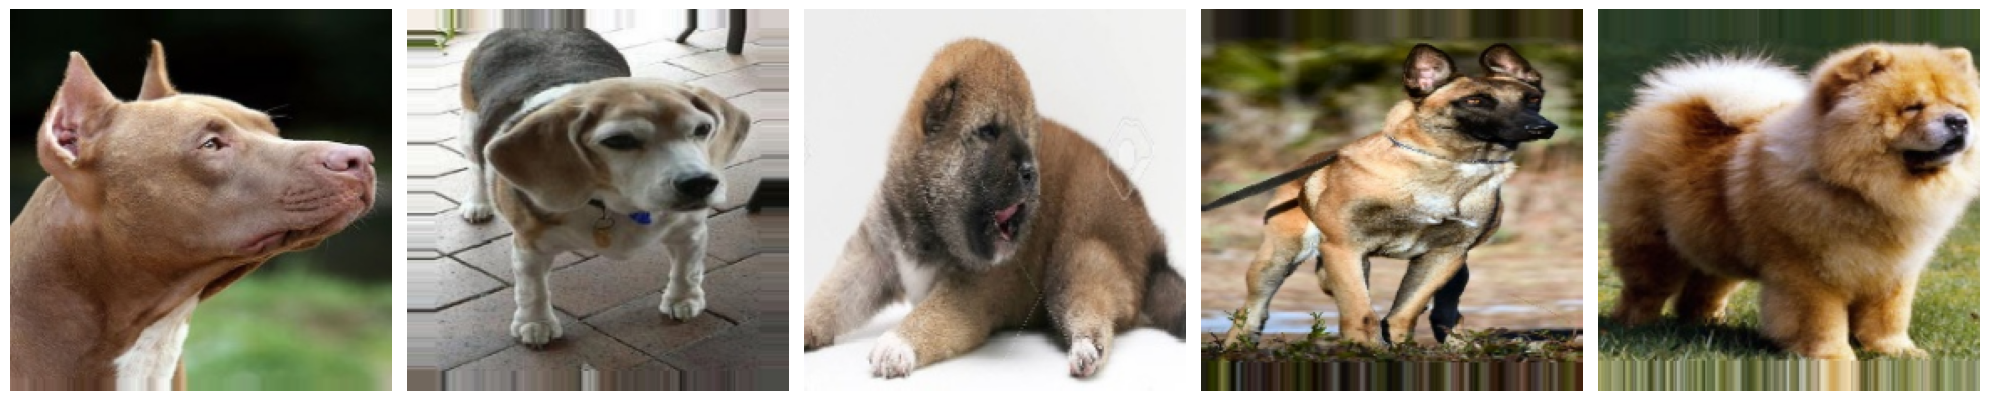

In [29]:
# test to ensure images look good

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


sample_training_images, _ = next(train_generator)
plot_images(sample_training_images[:5])

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 182s 482ms/step - accuracy: 0.2173 - loss: 3.2544 - val_accuracy: 0.0143 - val_loss: 5.4101
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 353ms/step - accuracy: 0.5735 - loss: 1.4495 - val_accuracy: 0.0143 - val_loss: 6.4633
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 88s 343ms/step - accuracy: 0.7064 - loss: 0.9833 - val_accuracy: 0.1686 - val_loss: 3.6833
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 89s 347ms/step - accuracy: 0.7583 - loss: 0.7779 - val_accuracy: 0.2829 - val_loss: 3.2253
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 89s 346ms/step - accuracy: 0.7875 - loss: 0.6515 - val_accuracy: 0.2171 - val_loss: 4.0085
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 88s 345ms/step - accuracy: 0.8474 - loss: 0.5010 - val_accuracy: 0.6943 - val_loss: 1.4034
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 91s 354ms/step - accuracy: 0.8559 - loss: 0.4456 - val_accuracy: 0.5543 - val_loss: 2.1055
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 88s 342ms/step - accuracy: 0.8829 - loss: 0.3796 - va

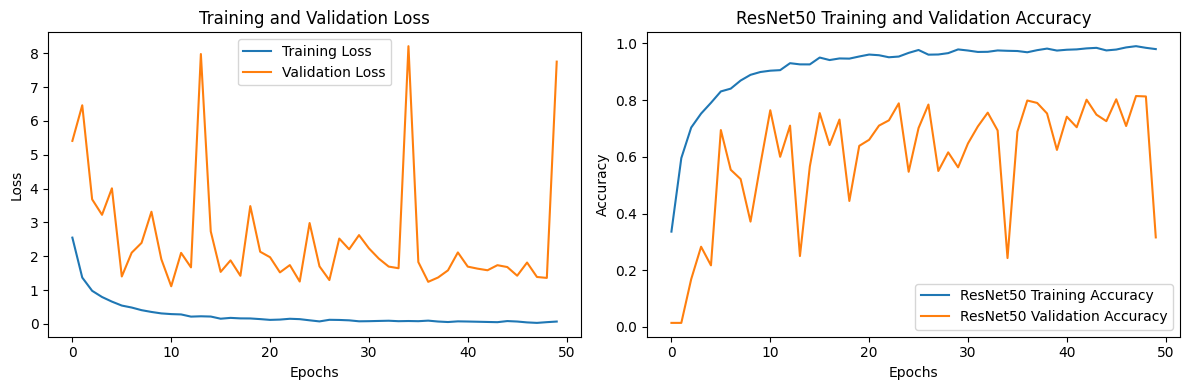

In [31]:
# Load model
base_model = ResNet50(weights='imagenet', include_top=False)

# Classifier
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(70, activation='softmax'))  # 70 to match our earlier shape

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_resnet = model.fit(train_generator,epochs=50, validation_data=validation_generator)

# Extract loss and accuracy for both training and validation
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='ResNet50 Training Accuracy')
plt.plot(epochs, val_accuracy, label='ResNet50 Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# save model for later.
model.save('/content/drive/My Drive/AA502_Computer_Vision/resnet50_base_dog_detection.h5')

Above attempt went really well!. Attempting resnet50 model again with adjustments for curiosity



Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 107s 375ms/step - accuracy: 0.0236 - loss: 4.2965 - val_accuracy: 0.0243 - val_loss: 4.2194
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 334ms/step - accuracy: 0.0435 - loss: 4.1260 - val_accuracy: 0.0529 - val_loss: 4.0783
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.0650 - loss: 4.0315 - val_accuracy: 0.0500 - val_loss: 3.9952
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.0843 - loss: 3.9522 - val_accuracy: 0.0729 - val_loss: 3.9089
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.0882 - loss: 3.8830 - val_accuracy: 0.0971 - val_loss: 3.8401
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 335ms/step - accuracy: 0.1056 - loss: 3.8197 - val_accuracy: 0.1071 - val_loss: 3.7853
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.1217 - loss: 3.7601 - val_accuracy: 0.1029 - val_loss: 3.6668
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.1347 - loss: 

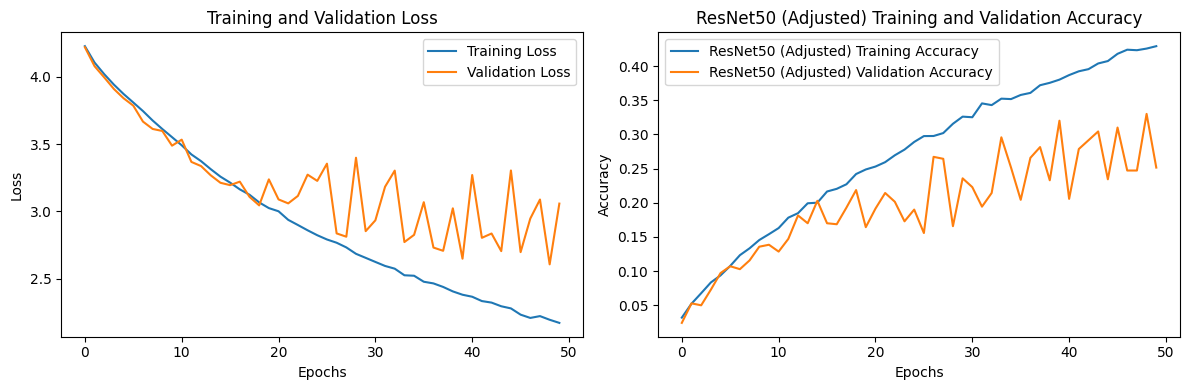

In [32]:
# making adjustments to Learning Rate, Freezing Layers, optimizers
from tensorflow.keras.optimizers import SGD # different optimizer

# same as before
base_model_adjusted = ResNet50(weights='imagenet', include_top=False)
model_adjusted = Sequential()
model_adjusted.add(base_model_adjusted)
model_adjusted.add(GlobalAveragePooling2D())
model_adjusted.add(Dense(70, activation='softmax'))

# Freeze layers - https://stackoverflow.com/questions/46610732/how-to-freeze-some-layers-when-fine-tune-resnet50
# https://www.linkedin.com/advice/0/how-can-you-determine-which-layers-freeze-when-okd8f#:~:text=1.-,Why%20Freeze%20Layers%3F,a%20similar%20structure%20or%20content.
for layer in base_model_adjusted.layers:
    layer.trainable = False
model_adjusted.save_weights("all_nontrainable.weights.h5")

base_model_adjusted = ResNet50(weights='imagenet', include_top=False)
model_adjusted = Sequential()
model_adjusted.add(base_model_adjusted)
model_adjusted.add(GlobalAveragePooling2D())
model_adjusted.add(Dense(70, activation='softmax'))

for layer in base_model_adjusted.layers[:-26]:
    layer.trainable = False
model_adjusted.load_weights("all_nontrainable.weights.h5")

# Compile
model_adjusted.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_resnet_adjusted = model_adjusted.fit(train_generator,epochs=50, validation_data=validation_generator)

# plotting
# Extract loss and accuracy for both training and validation
train_loss = history_resnet_adjusted.history['loss']
val_loss = history_resnet_adjusted.history['val_loss']
train_accuracy = history_resnet_adjusted.history['accuracy']
val_accuracy = history_resnet_adjusted.history['val_accuracy']

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='ResNet50 (Adjusted) Training Accuracy')
plt.plot(epochs, val_accuracy, label='ResNet50 (Adjusted) Validation Accuracy')
plt.title('ResNet50 (Adjusted) Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

model_adjusted.save('/content/drive/My Drive/AA502_Computer_Vision/resnet50_with_adjustments_dog_detection.h5')

CNN architecture


In [6]:
!pip install tensorflow.keras.layers
!pip install tensorflow.keras.optimizers
!pip install keras.models
!pip install keras.layers
!pip install keras.utils
!pip install keras.preprocessing.image

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers
ERROR: Could not find a version that satisfies the requirement tensorflow.keras.optimizers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.optimizers
ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=6651ce4ec2ed83c65703e362d5a0586cbdde95998bc13a6734218012e0af4756
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found f

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input , BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale, create directory paths
datagen = ImageDataGenerator(rescale=1./255,)

train_dir = path + '/train/'
test_dir = path + '/test/'
val_dir = path + '/valid/'

In [8]:
train_dataset = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(228,228),
    class_mode='categorical'
)

# Load testing data
test_dataset = datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(228,228),
    class_mode='categorical'
)
val_dataset = datagen.flow_from_directory(
    val_dir,
    batch_size=64,
    target_size=(228,228),
    class_mode='categorical'
)
num_classes = 70

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [9]:
input_shape = (228, 228, 3)

cnn_model = Sequential([
    Input(shape=input_shape),

    # Convolutional Blocks
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(70, activation='softmax')
])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.0294 - loss: 6.7250 - val_accuracy: 0.0157 - val_loss: 4.2481
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.0653 - loss: 4.1938 - val_accuracy: 0.0243 - val_loss: 4.3587
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.0839 - loss: 3.9796 - val_accuracy: 0.0271 - val_loss: 4.1904
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.1153 - loss: 3.7626 - val_accuracy: 0.0629 - val_loss: 4.0333
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.1382 - loss: 3.6284 - val_accuracy: 0.0529 - val_loss: 4.2365
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.1597 - loss: 3.4940 - val_accuracy: 0.0814 - val_loss: 3.8213
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.1858 - loss: 3.3436 - val_accuracy: 0.0829 - val_loss: 3.9402
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.2125 - loss: 3.1556 - val

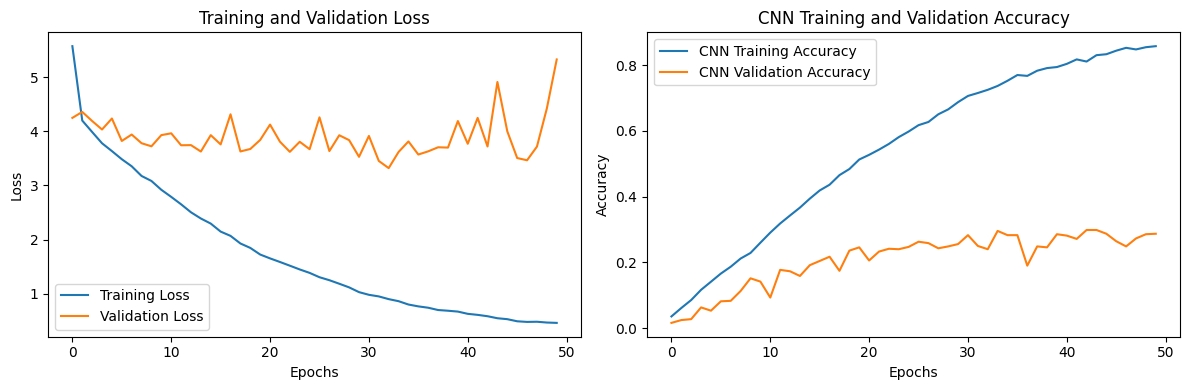

In [10]:
cnn_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(train_dataset, epochs=50, validation_data=val_dataset , batch_size=32 , verbose=1)

# plotting
# Extract loss and accuracy for both training and validation
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
train_accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='CNN Training Accuracy')
plt.plot(epochs, val_accuracy, label='CNN Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

cnn_model.save('/content/drive/My Drive/AA502_Computer_Vision/dog_cnn_model.h5')


Now  that we've trained resnet50/CNN models, running some evaluation on them using test sets from earlier. Validation accuracy stayed low, training accuracy was high

In [21]:
from tensorflow.keras.models import load_model

resnet50_base_model = load_model('/content/drive/My Drive/AA502_Computer_Vision/resnet50_base_dog_detection.h5')
resnet50_adjusted_model = load_model('/content/drive/My Drive/AA502_Computer_Vision/resnet50_with_adjustments_dog_detection.h5')
cnn_model = load_model('/content/drive/My Drive/AA502_Computer_Vision/dog_cnn_model.h5')

resnet50_base_model_predictions = resnet50_base_model.predict(test_generator)
resnet50_adjusted_model_predictions = resnet50_adjusted_model.predict(test_generator)
cnn_model_predictions = cnn_model.predict(test_dataset)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the mapping of class indices to breed names
class_indices = train_dataset.class_indices
index_to_breed = {v: k for k, v in class_indices.items()}  # Reverse the dictionary to map indices to breed names

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    conf_mat = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 15))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Function to compute y_true and y_pred for the entire dataset
def compute_predictions(test_data, model):
    y_true = []
    y_pred = []

    for batch, labels in test_data:
        preds = model.predict(batch)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
        if len(y_true) >= test_data.samples:
            break

    return y_true, y_pred

#resnet50 base model


# Get the list of class names from the index to breed mapping
class_names = list(index_to_breed.values())

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


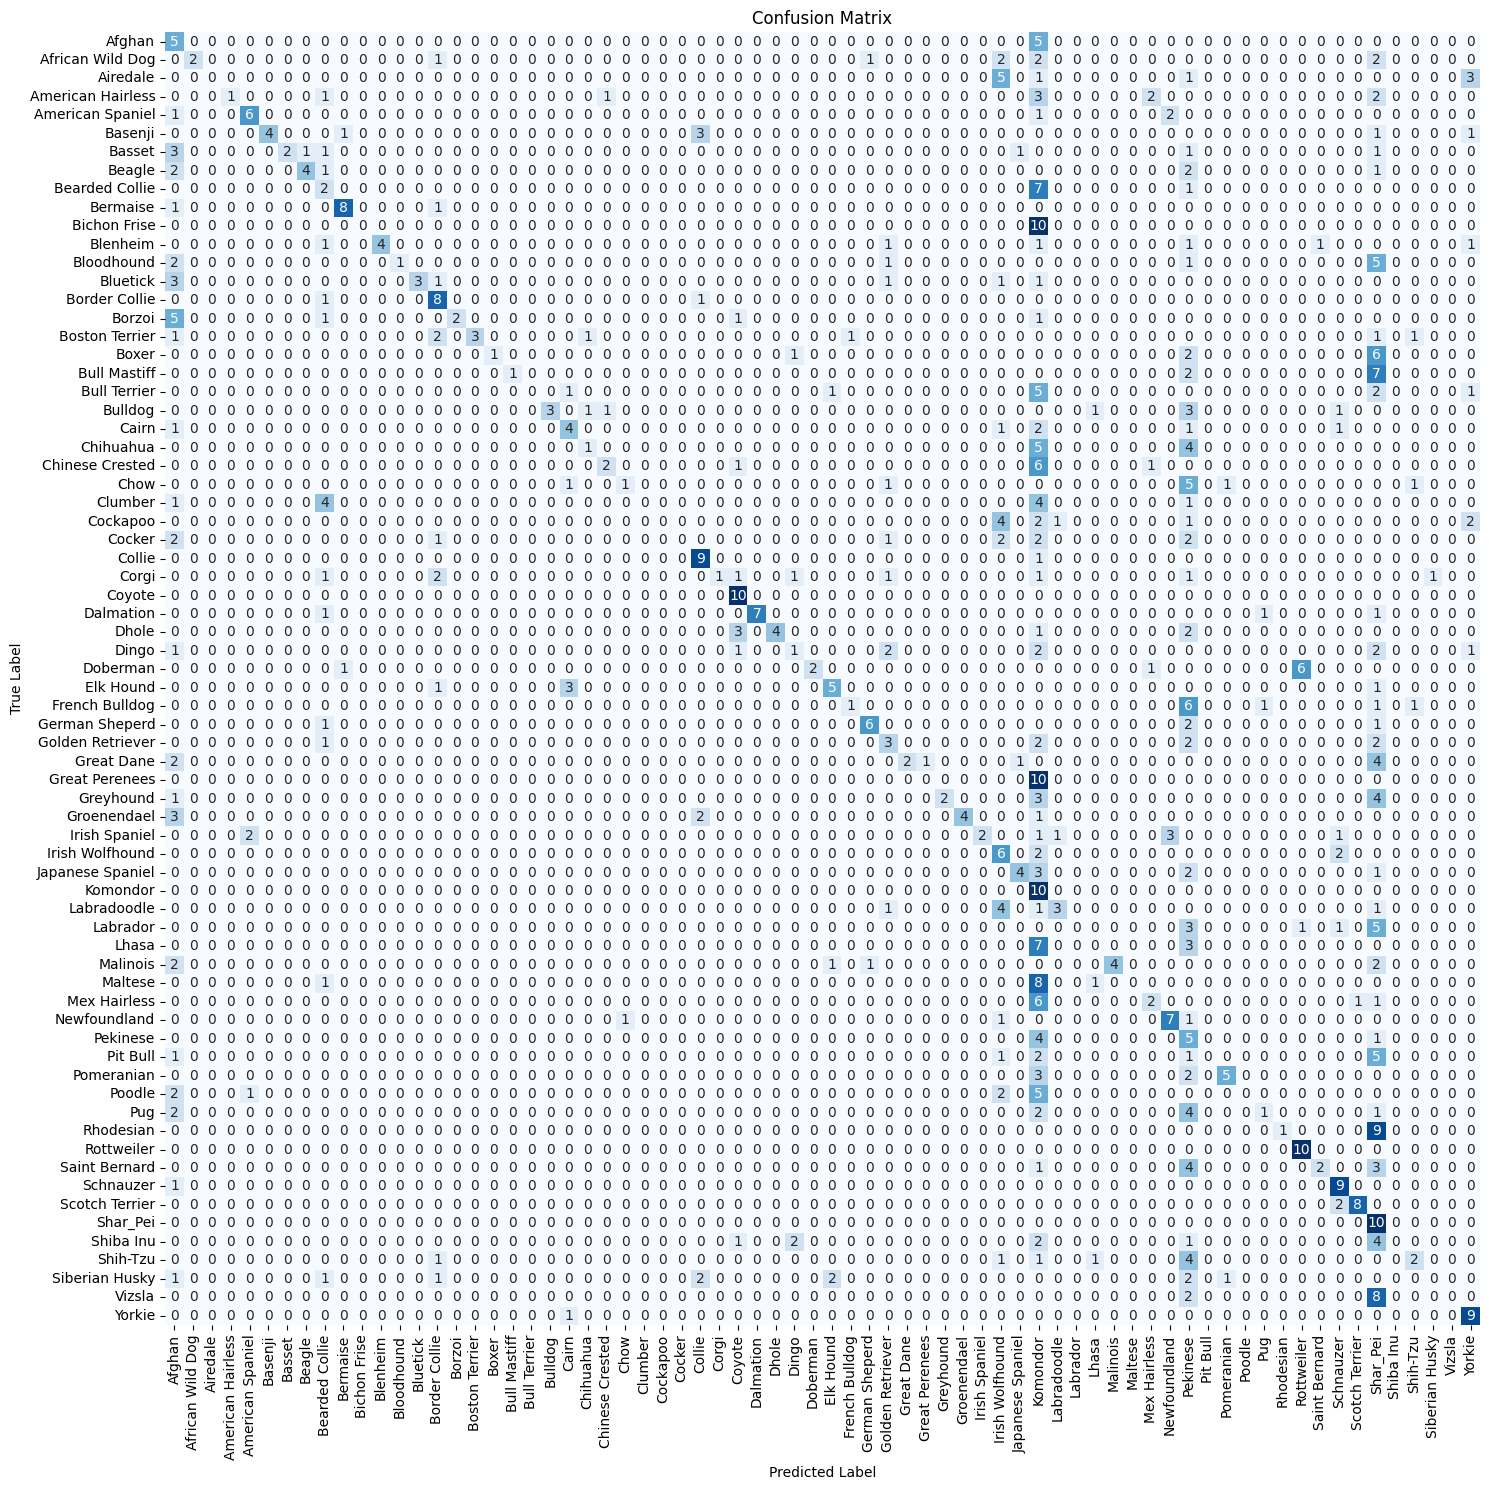

Classification Report (resnet50):
                   precision    recall  f1-score   support

           Afghan       0.12      0.50      0.19        10
 African Wild Dog       1.00      0.20      0.33        10
         Airedale       0.00      0.00      0.00        10
American Hairless       1.00      0.10      0.18        10
 American Spaniel       0.67      0.60      0.63        10
          Basenji       1.00      0.40      0.57        10
           Basset       1.00      0.20      0.33        10
           Beagle       0.80      0.40      0.53        10
   Bearded Collie       0.11      0.20      0.14        10
         Bermaise       0.80      0.80      0.80        10
     Bichon Frise       0.00      0.00      0.00        10
         Blenheim       1.00      0.40      0.57        10
       Bloodhound       1.00      0.10      0.18        10
         Bluetick       1.00      0.30      0.46        10
    Border Collie       0.42      0.80      0.55        10
           Borzoi    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
#resnet50 base model
# Get predictions and true labels
y_true, y_pred = compute_predictions(test_generator, resnet50_base_model)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Print the classification report
print("Classification Report (resnet50):")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


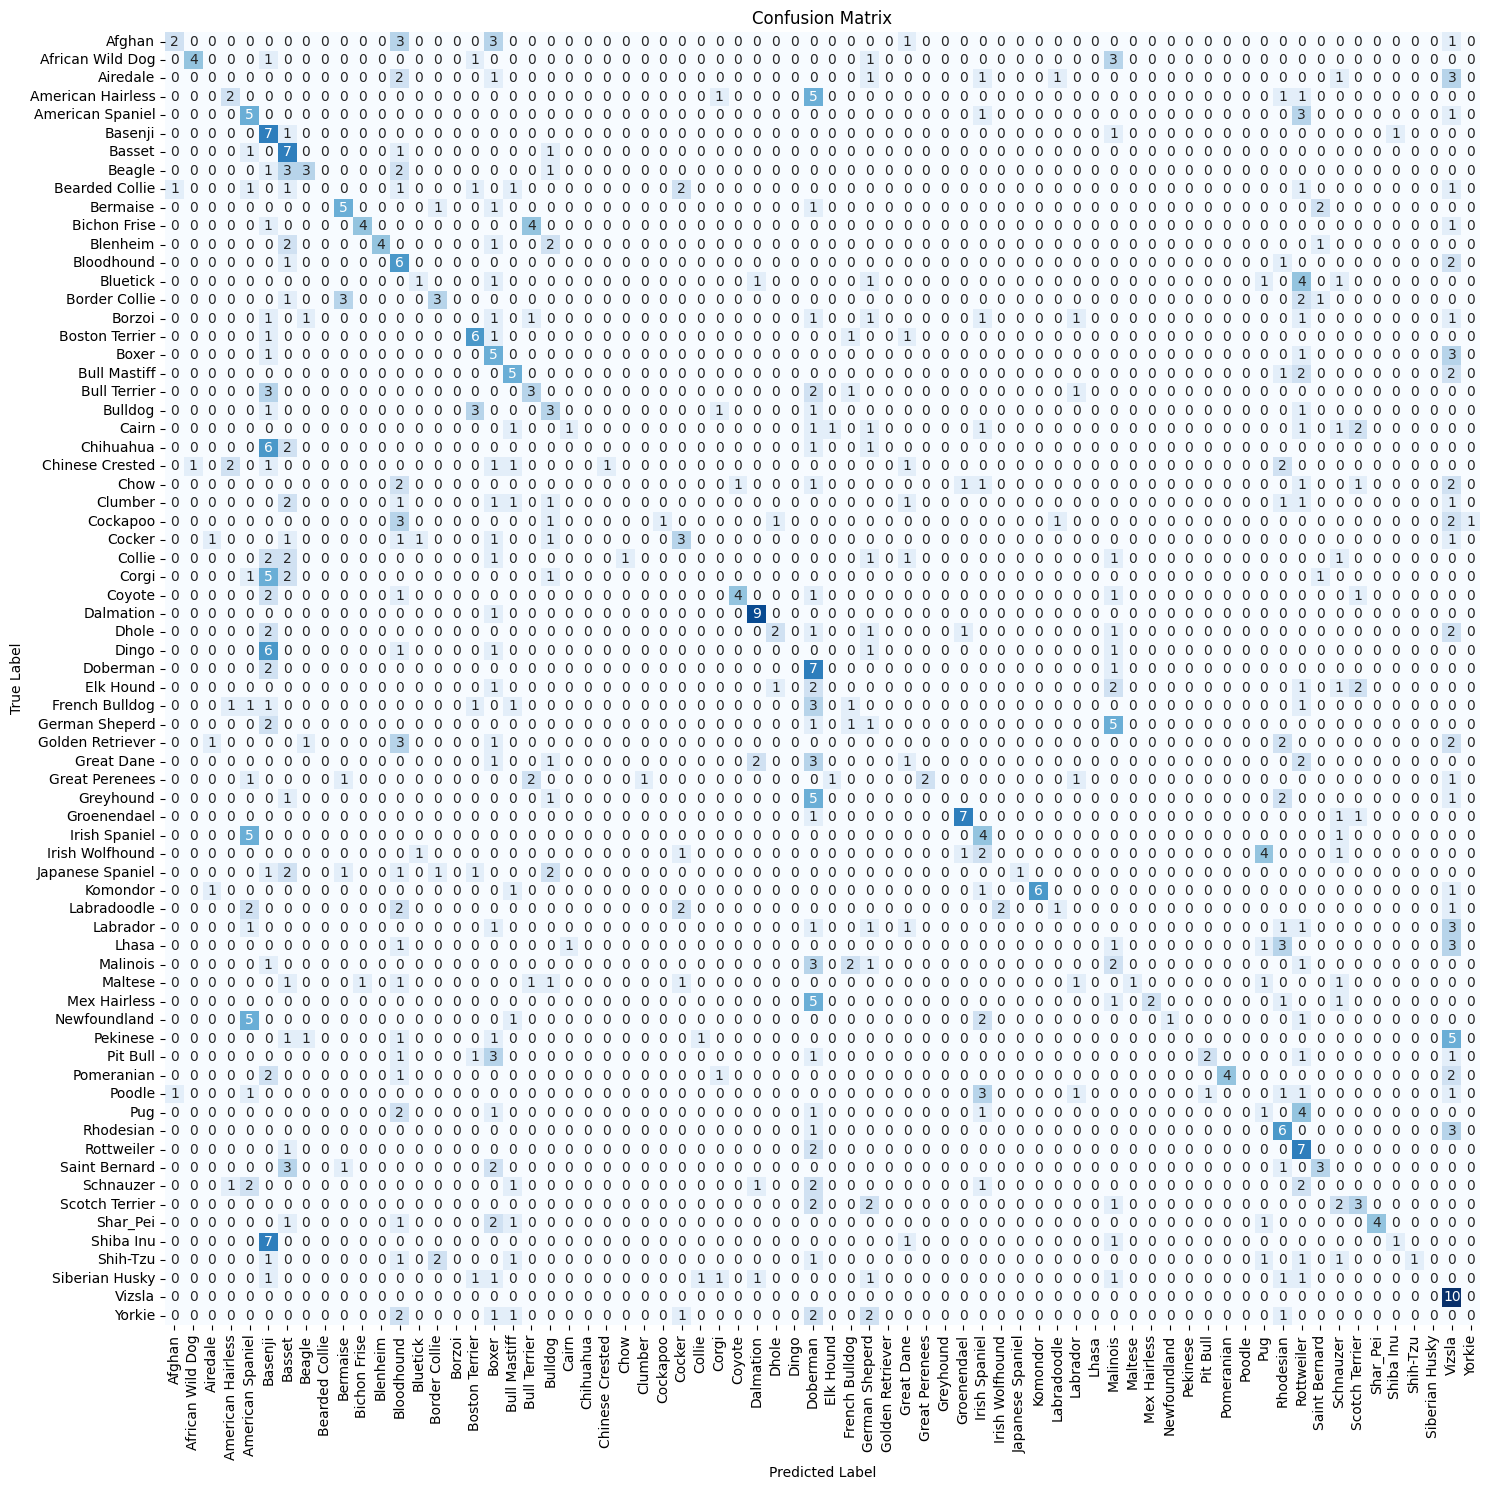

Classification Report (resnet50 adjusted):
                   precision    recall  f1-score   support

           Afghan       0.50      0.20      0.29        10
 African Wild Dog       0.80      0.40      0.53        10
         Airedale       0.00      0.00      0.00        10
American Hairless       0.33      0.20      0.25        10
 American Spaniel       0.19      0.50      0.28        10
          Basenji       0.12      0.70      0.20        10
           Basset       0.20      0.70      0.31        10
           Beagle       0.50      0.30      0.38        10
   Bearded Collie       0.00      0.00      0.00        10
         Bermaise       0.45      0.50      0.48        10
     Bichon Frise       0.80      0.40      0.53        10
         Blenheim       1.00      0.40      0.57        10
       Bloodhound       0.15      0.60      0.24        10
         Bluetick       0.33      0.10      0.15        10
    Border Collie       0.43      0.30      0.35        10
           B

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
#resnet50 adjusted
# Get predictions and true labels
y_true, y_pred = compute_predictions(test_generator, resnet50_adjusted_model)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

print("Classification Report (resnet50 adjusted):")
print(classification_report(y_true, y_pred, target_names=class_names))



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


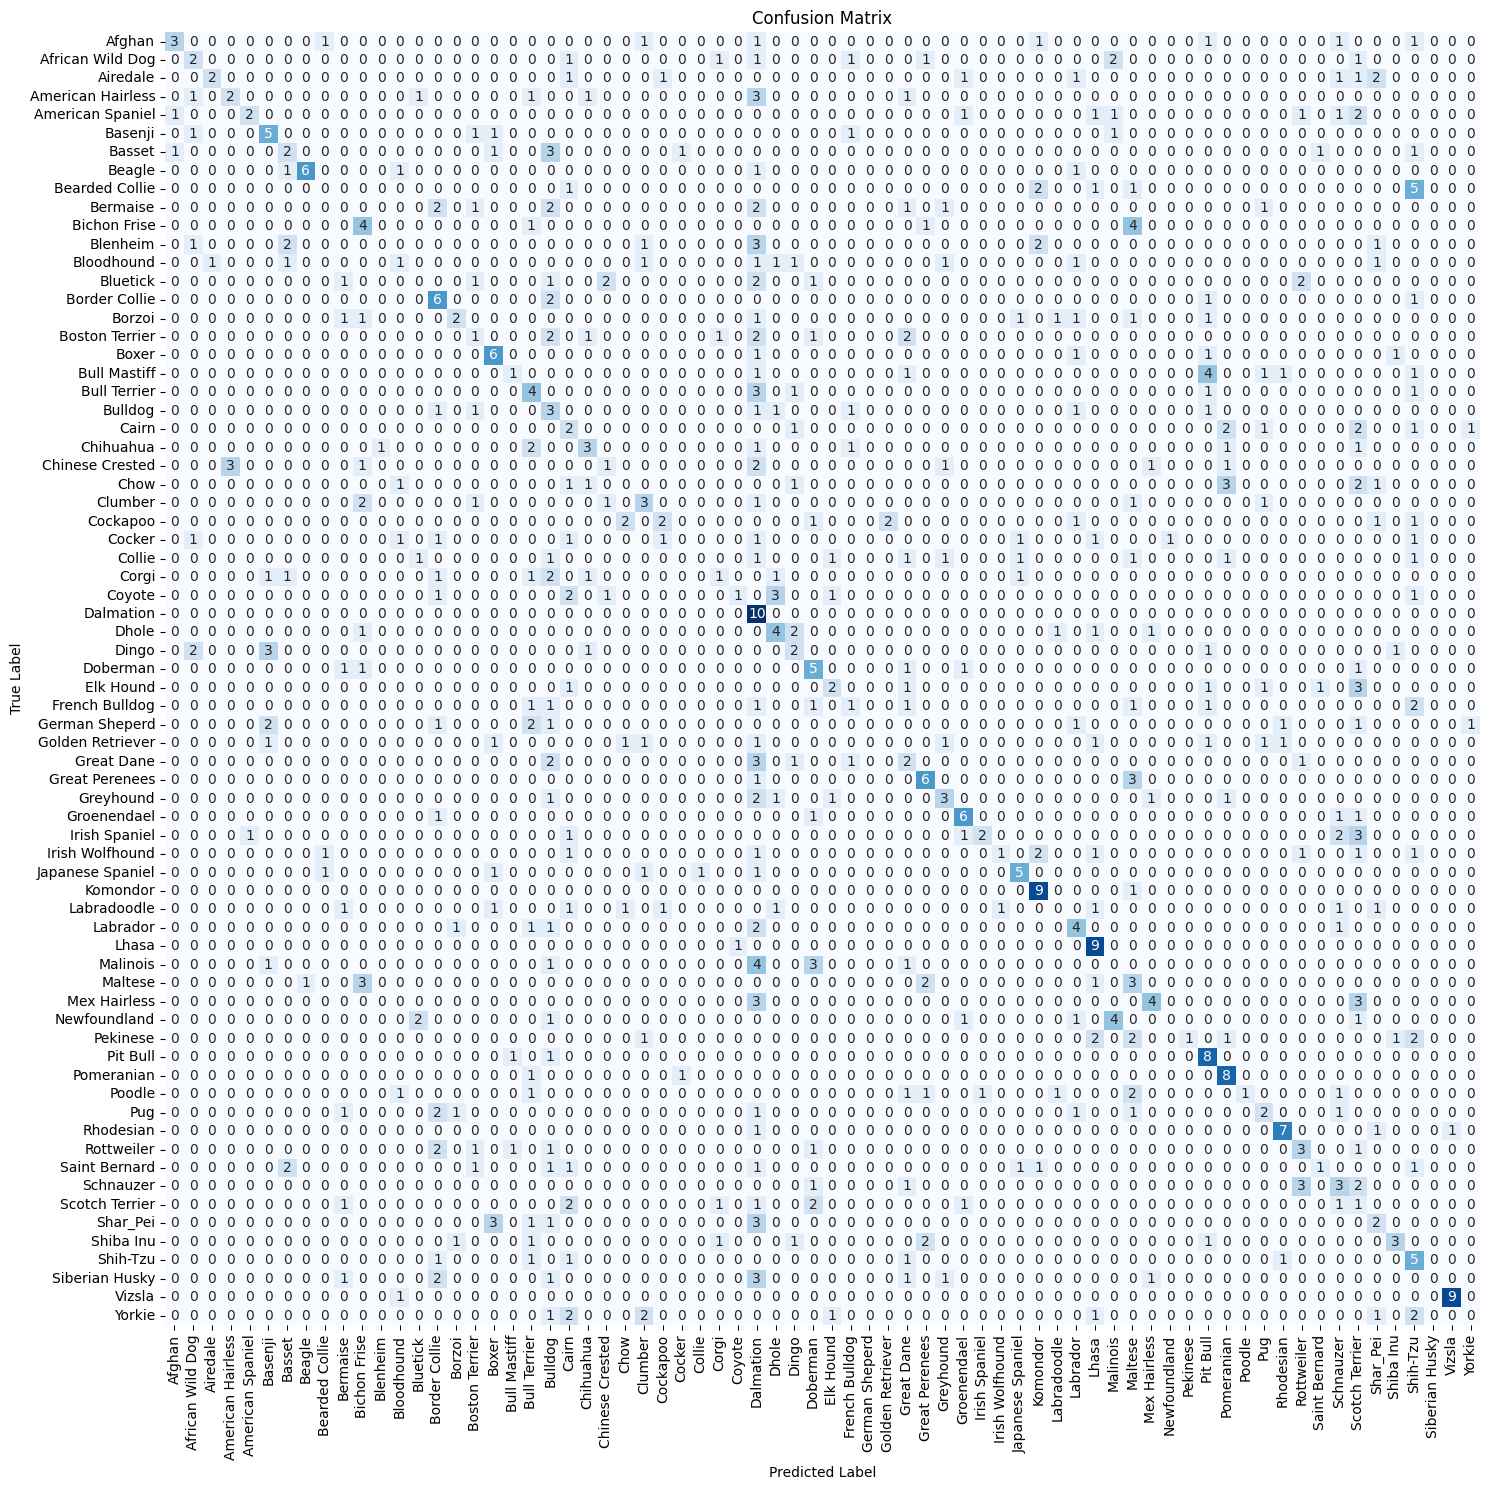

Classification Report (resnet50 adjusted):
                   precision    recall  f1-score   support

           Afghan       0.60      0.30      0.40        10
 African Wild Dog       0.25      0.20      0.22        10
         Airedale       0.67      0.20      0.31        10
American Hairless       0.40      0.20      0.27        10
 American Spaniel       0.67      0.20      0.31        10
          Basenji       0.38      0.50      0.43        10
           Basset       0.22      0.20      0.21        10
           Beagle       0.86      0.60      0.71        10
   Bearded Collie       0.00      0.00      0.00        10
         Bermaise       0.00      0.00      0.00        10
     Bichon Frise       0.31      0.40      0.35        10
         Blenheim       0.00      0.00      0.00        10
       Bloodhound       0.17      0.10      0.12        10
         Bluetick       0.00      0.00      0.00        10
    Border Collie       0.29      0.60      0.39        10
           B

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [19]:
#cnn model
#resnet50 adjusted
# Get predictions and true labels
y_true, y_pred = compute_predictions(test_dataset, cnn_model)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

print("Classification Report (resnet50 adjusted):")
print(classification_report(y_true, y_pred, target_names=class_names))


print("Classification Report (cnn model):")
print(classification_report(y_true, y_pred, target_names=class_names))

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

resnet50_predictions = np.argmax(resnet50_base_model_predictions, axis=1)
resnet50_adjusted_predictions = np.argmax(resnet50_adjusted_model_predictions, axis=1)
cnn_predictions = np.argmax(cnn_model_predictions, axis=1)

# same just repeating
y_true = test_generator.classes
y_true_cnn = test_dataset.classes


# Evaluate ResNet50
resnet50_acc = accuracy_score(y_true, resnet50_predictions)
resnet50_precision = precision_score(y_true, resnet50_predictions, average='macro')
resnet50_recall_score = recall_score(y_true, resnet50_predictions, average='macro')
resnet50_f1_score = f1_score(y_true, resnet50_predictions, average='macro')
resnet50_confusion_matrix = confusion_matrix(y_true, resnet50_predictions)

print("resnet50 base model accuracy: ", resnet50_acc)
print("resnet50 base model precision: ", resnet50_precision)
print("resnet50 base model recall: ", resnet50_recall_score)
print("resnet50 base model f1: ", resnet50_f1_score)
print("resnet50 base model confusion matrix: ", resnet50_confusion_matrix)

# non-base model
resnet50_adj_acc = accuracy_score(y_true, resnet50_adjusted_predictions)
resnet50_adj_precision = precision_score(y_true, resnet50_adjusted_predictions, average='macro')
resnet50_adj_recall_score = recall_score(y_true, resnet50_adjusted_predictions, average='macro')
resnet50_adj_f1_score = f1_score(y_true, resnet50_adjusted_predictions, average='macro')
resnet50_adj_confusion_matrix = confusion_matrix(y_true, resnet50_adjusted_predictions)

print("resnet50 adj model accuracy: ", resnet50_adj_acc)
print("resnet50 adj model precision: ", resnet50_adj_precision)
print("resnet50 adj model recall: ", resnet50_adj_recall_score)
print("resnet50 adj model f1: ", resnet50_adj_f1_score)
print("resnet50 adj model confusion matrix: ", resnet50_adj_confusion_matrix)

# # Evaluate CNN
cnn_acc = accuracy_score(y_true, cnn_predictions)
cnn_precision = precision_score(y_true, cnn_predictions, average='macro')
cnn_recall_score = recall_score(y_true, cnn_predictions, average='macro')
cnn_f1_score = f1_score(y_true, cnn_predictions, average='macro')
cnn_confusion_matrix = confusion_matrix(y_true, cnn_predictions)

print("cnn model accuracy: ", cnn_acc)
print("cnn model precision: ", cnn_precision)
print("cnn model recall: ", cnn_recall_score)
print("cnn model f1: ", cnn_f1_score)
print("cnn model confusion matrix: ", cnn_confusion_matrix)

resnet50 base model accuracy:  0.011428571428571429
resnet50 base model precision:  0.012747299406380558
resnet50 base model recall:  0.011428571428571429
resnet50 base model f1:  0.008497776288892735
resnet50 base model confusion matrix:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]
resnet50 adj model accuracy:  0.011428571428571429
resnet50 adj model precision:  0.004228146933353318
resnet50 adj model recall:  0.011428571428571429
resnet50 adj model f1:  0.005599922649203101
resnet50 adj model confusion matrix:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]
cnn model accuracy:  0.014285714285714285
cnn model precision:  0.013421947726459004
cnn model recall:  0.014285714285714285
cnn model f1:  0.012100863787365914
cnn model confusion matrix:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation scores were quite poor. Trying on an image

In [23]:
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/My Drive/AA502_Computer_Vision/DSC01372_Original.jpg'
img = image.load_img(img_path, target_size=(228, 228))  # Resize to match our input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# test image against all models
resnet50_base_model_predictions = resnet50_base_model.predict(img_array)
resnet50_adjusted_model_predictions = resnet50_adjusted_model.predict(img_array)
cnn_model_predictions = cnn_model.predict(img_array)

resnet50_predictions_for_single_image = np.argmax(resnet50_base_model_predictions, axis=1)
resnet50_adjusted_predictions_for_single_image = np.argmax(resnet50_adjusted_model_predictions, axis=1)
cnn_predictions_for_single_image = np.argmax(cnn_model_predictions, axis=1)

# to get breed predicted
class_indices = test_generator.class_indices
index_to_class = {a: b for b, a in class_indices.items()}

print("ResNet50 Prediction:", index_to_class[resnet50_predictions_for_single_image[0]])
print("ResNet50 adjusted Prediction:", index_to_class[resnet50_adjusted_predictions_for_single_image[0]])
print("CNN Prediction:", index_to_class[cnn_predictions_for_single_image[0]])




1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
ResNet50 Prediction: Komondor
ResNet50 adjusted Prediction: Doberman
CNN Prediction: Bichon Frise


Dog in single image was supposed to be (Akita) so it doesn't bode well for resnet50 and cnn models did not come close. That said, Akita's aren't in the available indices so maybe it's working as intended.